# Precision-recall evaluation on CIFAR10
Deterministic NN vs Bayesian NN with Gaussian posterior

### Part 0 : Loading models and data

In [1]:
import os
import yaml
import torch
import numpy as np
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.insert(0, '../')
import dataloader as dload
from models import model_wrapper as modelw

ModuleNotFoundError: No module named 'dataloader'

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# CIFAR10 self-confid models
MODELS = {'lenet':{'config_path':'/share/DEEPLEARNING/ccorbiere/logs/cifar_lenet_baseline/config_1.yaml', 
                   'ckpt_path':'/share/DEEPLEARNING/ccorbiere/logs/cifar_lenet_baseline/model_epoch_496.ckpt',
                   'mode':[]},
          'resnet50':{'config_path':'/share/DEEPLEARNING/ccorbiere/logs/cifar_resnet50_baseline/config_1.yaml', 
                      'ckpt_path':'/share/DEEPLEARNING/ccorbiere/logs/cifar_resnet50_baseline/model_epoch_483.ckpt',
                      'mode':[]},
          'lenet_selfconfid':{'config_path':'/share/DEEPLEARNING/ccorbiere/logs/cifar_lenet_selfconfid/config_1.yaml', 
                              'ckpt_path':'/share/DEEPLEARNING/ccorbiere/logs/cifar_lenet_selfconfid/model_epoch_370.ckpt',
                              'mode':['self_confid']},
          'resnet_selfconfid':{'config_path':'/share/DEEPLEARNING/ccorbiere/logs/cifar_resnet_selfconfid/config_1.yaml', 
                              'ckpt_path':'/share/DEEPLEARNING/ccorbiere/logs/cifar_resnet_selfconfid/model_epoch_003.ckpt',
                              'mode':['self_confid']}
         }

In [4]:
# SVHN models
MODELS = {'lenet':{'config_path':'/share/DEEPLEARNING/ccorbiere/logs/svhn_lenet_faster/config_1.yaml', 
                   'ckpt_path':'/share/DEEPLEARNING/ccorbiere/logs/svhn_lenet_faster/model_epoch_435.ckpt',
                   'mode':[]},
          'resnet50':{'config_path':'/share/DEEPLEARNING/ccorbiere/logs/svhn_resnet50_faster/config_1.yaml', 
                   'ckpt_path':'/share/DEEPLEARNING/ccorbiere/logs/svhn_resnet50_faster/model_epoch_234.ckpt',
                   'mode':[]}
         }

In [5]:
# MNIST BNN models
MODELS = {'baseline':{'config_path':'/share/DEEPLEARNING/ccorbiere/logs/twohidden_mnist_faster/config_1.yaml', 
                   'ckpt_path':'/share/DEEPLEARNING/ccorbiere/logs/twohidden_mnist_faster/model_epoch_349.ckpt',
                   'mode':[]},
          'dropout':{'config_path':'/share/DEEPLEARNING/ccorbiere/logs/twohidden_mnist_dropout/config_1.yaml', 
                   'ckpt_path':'/share/DEEPLEARNING/ccorbiere/logs/twohidden_mnist_dropout/model_epoch_498.ckpt',
                   'mode':[]},
          'bayesian_scale':{'config_path':'/share/DEEPLEARNING/ccorbiere/logs/mnist_bayesian_twohidden_scale/config_1.yaml', 
                              'ckpt_path':'/share/DEEPLEARNING/ccorbiere/logs/mnist_bayesian_twohidden_scale/model_epoch_012.ckpt',
                              'mode':['bayesian']},
          'bayesian_gaussian':{'config_path':'/share/DEEPLEARNING/ccorbiere/logs/mnist_bayesian_twohidden_gaussian/config_1.yaml', 
                              'ckpt_path':'/share/DEEPLEARNING/ccorbiere/logs/mnist_bayesian_twohidden_gaussian/model_epoch_012.ckpt',
                              'mode':['bayesian']}
         }


In [6]:
# CIFAR10 lenet models
MODELS = {'lenet_baseline':{'config_path':'/share/DEEPLEARNING/ccorbiere/logs/cifar/cifar_lenet_baseline/config_1.yaml', 
                   'ckpt_path':'/share/DEEPLEARNING/ccorbiere/logs/cifar/cifar_lenet_baseline/model_epoch_496.ckpt',
                   'mode':[]},
          'lenet_smoothing':{'config_path':'/share/DEEPLEARNING/ccorbiere/logs/cifar/cifar_lenet_smoothing/config_1.yaml', 
                              'ckpt_path':'/share/DEEPLEARNING/ccorbiere/logs/cifar/cifar_lenet_smoothing/model_epoch_480.ckpt',
                              'mode':[]},
          'lenet_selfconfid':{'config_path':'/share/DEEPLEARNING/ccorbiere/logs/cifar/cifar_lenet_selfconfid/config_1.yaml', 
                              'ckpt_path':'/share/DEEPLEARNING/ccorbiere/logs/cifar/cifar_lenet_selfconfid/model_epoch_370.ckpt',
                              'mode':[]},
          'lenet_heter':{'config_path':'/share/DEEPLEARNING/ccorbiere/logs/cifar/cifar_lenet_heter/config_1.yaml', 
                              'ckpt_path':'/share/DEEPLEARNING/ccorbiere/logs/cifar/cifar_lenet_heter/model_epoch_472.ckpt',
                              'mode':['heter']}
         }

In [7]:
# CIFAR10 resnet models
MODELS = {'resnet50':{'config_path':'/share/DEEPLEARNING/ccorbiere/logs/cifar_resnet50_baseline/config_1.yaml', 
                      'ckpt_path':'/share/DEEPLEARNING/ccorbiere/logs/cifar_resnet50_baseline/model_epoch_483.ckpt',
                      'mode':[]},
          'resnet50_smoothing':{'config_path':'/share/DEEPLEARNING/ccorbiere/logs/cifar_resnet50_smoothing/config_1.yaml', 
                              'ckpt_path':'/share/DEEPLEARNING/ccorbiere/logs/cifar_resnet50_smoothing/model_epoch_449.ckpt',
                              'mode':[]},
         }

In [19]:
# CIFAR10 resnet models
MODELS = {'resnet50_baseline':{'config_path':'/share/DEEPLEARNING/ccorbiere/logs/cifar/cifar_resnet50_baseline/config_1.yaml', 
                      'ckpt_path':'/share/DEEPLEARNING/ccorbiere/logs/cifar/cifar_resnet50_baseline/model_epoch_483.ckpt',
                      'mode':[]},
          'resnet50_ft_selfconfid_w1_bigger_new':{'config_path':'/share/DEEPLEARNING/ccorbiere/logs/cifar/cifar_resnet50_ft_selfconfid_w1_sig_bigger_new_slowerx2/config_1.yaml', 
                              'ckpt_path':'/share/DEEPLEARNING/ccorbiere/logs/cifar/cifar_resnet50_ft_selfconfid_w1_sig_bigger_new_slowerx2/model_epoch_024.ckpt',
                              'mode':['self_confid']},
          'resnet50_oodconfid_hr':{'config_path':'/share/DEEPLEARNING/ccorbiere/logs/cifar/cifar_resnet50_hr_oodconfid/config_1.yaml', 
                              'ckpt_path':'/share/DEEPLEARNING/ccorbiere/logs/cifar/cifar_resnet50_hr_oodconfid/model_epoch_426.ckpt',
                              'mode':['self_confid']},
         }

In [23]:
# CIFAR10 models
MODELS = {'lenet_heter':{'config_path':'/share/DEEPLEARNING/ccorbiere/logs/cifar_lenet_heter/config_1.yaml', 
                              'ckpt_path':'/share/DEEPLEARNING/ccorbiere/logs/cifar_lenet_heter/model_epoch_472.ckpt',
                              'mode':['heter']}
         }

In [47]:
# CIFAR10 models
MODELS = {'lenet_baseline':{'config_path':'/home/docker_user/shared/ccorbiere/logs/cifar/cifar_lenet_baseline_AP/config_1.yaml', 
                   'ckpt_path':'/home/docker_user/shared/ccorbiere/logs/cifar/cifar_lenet_baseline_AP/model_epoch_421.ckpt',
                   'mode':[]},
          'lenet_selfconfidtoy_w1_sig_bigger':{'config_path':'/home/docker_user/shared/ccorbiere/logs/cifar/cifar_lenet_selfconfid_ft_w1_bigger_faster_AP/config_1.yaml', 
                              'ckpt_path':'/home/docker_user/shared/ccorbiere/logs/cifar/cifar_lenet_selfconfid_ft_w1_bigger_faster_AP/model_epoch_465.ckpt',
                              'mode':['self_confid']},
          'lenet_oodconfid_hr_bigger_nocontrol':{'config_path':'/home/docker_user/shared/ccorbiere/logs/cifar/cifar_lenet_oodconfid_hr_bigger_nocontrol/config_1.yaml', 
                              'ckpt_path':'/home/docker_user/shared/ccorbiere/logs/cifar/cifar_lenet_oodconfid_hr_bigger_nocontrol/model_epoch_494.ckpt',
                              'mode':['self_confid']},
         }

In [ ]:
# CIFAR10 models
MODELS = {'lenet_baseline':{'config_path':'/share/DEEPLEARNING/ccorbiere/logs/cifar/cifar_lenet_baseline/config_1.yaml', 
                   'ckpt_path':'/share/DEEPLEARNING/ccorbiere/logs/cifar/cifar_lenet_baseline/model_epoch_496.ckpt',
                   'mode':[]},
          'lenet_selfconfidtoy_w1_sig_bigger':{'config_path':'/share/DEEPLEARNING/ccorbiere/logs/cifar/cifar_lenet_ft_selfconfidtoy_w1_sigmoid_bigger/config_1.yaml', 
                              'ckpt_path':'/share/DEEPLEARNING/ccorbiere/logs/cifar/cifar_lenet_ft_selfconfidtoy_w1_sigmoid_bigger/model_epoch_432.ckpt',
                              'mode':['self_confid']},
          'lenet_oodconfid_hr_bigger_nocontrol':{'config_path':'/share/DEEPLEARNING/ccorbiere/logs/cifar/cifar_lenet_oodconfid_hr_bigger_nocontrol/config_1.yaml', 
                              'ckpt_path':'/share/DEEPLEARNING/ccorbiere/logs/cifar/cifar_lenet_oodconfid_hr_bigger_nocontrol/model_epoch_482.ckpt',
                              'mode':['self_confid']},
         }

In [1]:
# CIFAR10 resnet models
MODELS = {'resnet50_baseline':{'config_path':'/home/docker_user/shared/ccorbiere/logs/cifar/cifar_resnet50_baseline_AP/config_1.yaml', 
                      'ckpt_path':'/home/docker_user/shared/ccorbiere/logs/cifar/cifar_resnet50_baseline_AP/model_epoch_481.ckpt',
                      'mode':[]},
          'resnet50_ft_selfconfid_w1_bigger':{'config_path':'/home/docker_user/shared/ccorbiere/logs/cifar/cifar_resnet50_selfconfid_ft_w1_bigger_lr3_AP/config_1.yaml', 
                              'ckpt_path':'/home/docker_user/shared/ccorbiere/logs/cifar/cifar_resnet50_selfconfid_ft_w1_bigger_lr3_AP/model_epoch_095.ckpt',
                              'mode':['self_confid']},
          'resnet50_oodconfid_hr':{'config_path':'/home/docker_user/shared/ccorbiere/logs/cifar/cifar_resnet50_oodconfid_hr_AP/config_1.yaml', 
                              'ckpt_path':'/home/docker_user/shared/ccorbiere/logs/cifar/cifar_resnet50_oodconfid_hr_AP/model_epoch_491.ckpt',
                              'mode':['self_confid']},
         }

In [2]:
MODELS = {'lenet_baseline':{'config_path':'/share/DEEPLEARNING/ccorbiere/logs/cifar/ap/cifar_lenet_baseline/config_1.yaml', 
                   'ckpt_path':'/share/DEEPLEARNING/ccorbiere/logs/cifar/ap/cifar_lenet_baseline/model_epoch_496.ckpt',
                   'mode':[]}}

In [3]:
models = []
for i,m in enumerate(MODELS):
    with open(MODELS[m]['config_path'], 'r') as f:
        config_args = yaml.load(f)
        config_args['data_dir']= os.path.join('..',config_args['data_dir'])
        if 'sig' not in m:
            config_args['sigmoid']=False
             
    # Initialize and load model
    model = modelw.get_model(config_args, device).to(device)
    print('MODEL {}: {}'.format(i,config_args['model_name']))
    checkpoint = torch.load('{}'.format(MODELS[m]['ckpt_path']))
    model.load_state_dict(checkpoint['model_state_dict'])
    MODELS[m]['model'] = model

FileNotFoundError: [Errno 2] No such file or directory: '/share/DEEPLEARNING/ccorbiere/logs/cifar/ap/cifar_lenet_baseline/config_1.yaml'

In [6]:
# Get data loader
print('Loading dataset {}'.format(config_args['dataset']))
train_loader, test_loader = dload.DATALOADERS[config_args['dataset']](
    data_dir=config_args['data_dir'],
    batch_size=config_args['batch_size'],
    valid_size=config_args['valid_size'],
    num_workers=config_args['num_workers'])

Loading dataset cifar10
Files already downloaded and verified
Files already downloaded and verified


## Part 1: plot precision-recall curves

In [7]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import torch.nn.functional as F

In [8]:
def one_hot_embedding(labels, num_classes):
    """Embedding labels to one-hot form.

    Args:
      labels: (LongTensor) class labels, sized [N,].
      num_classes: (int) number of classes.

    Returns:
      (tensor) encoded labels, sized [N, #classes].
    """
    y = torch.eye(num_classes) 
    return y[labels] 

In [9]:
def uncertainty_estimate(data, mode='entropy', iters=10):    
    if mode=='entropy':
        outputs = torch.stack([F.softmax(model(data), dim=1) for i in range(iters)], dim=1)
        y_mean = outputs.mean(dim=1)
        uncertainty = -(y_mean*torch.log(y_mean)).sum(dim=1)
        uncertainty = 1 - torch.sigmoid(uncertainty)
        pred = y_mean.argmax(dim=1)
        
    if mode=='logit-normal':
        logit_outputs = torch.stack([model(data) for i in range(iters)], dim=1)
        kappla_var = 1/torch.sqrt(1+ np.pi*logit_outputs.var(dim=1)/8)
        outputs = F.softmax(logit_outputs.mean(dim=1)*kappla_var, dim=1)
        uncertainty, pred = outputs.max(dim=1) 
        
    if mode=='probit':
        logit_outputs = torch.stack([model(data) for i in range(iters)], dim=1)
        kappla_var = 1/torch.sqrt(1+ np.pi*logit_outputs.var(dim=1)/8)
        inv_sig_output = 1/(torch.sigmoid(logit_outputs.mean(dim=1)*kappla_var))
        outputs = 1/(2-10+inv_sig_output.sum(dim=1, keepdim=True) - inv_sig_output)
        uncertainty, pred = outputs.max(dim=1)
    
    return uncertainty, pred

In [24]:
def predict_test_set(model, mode='normal', verbose=True):
    accurate = []
    proba_pred = []
    correct = 0
    model.eval()
    a_eq, a_neq, nb_neq, nb_eq = 0,0,0,0
    with torch.no_grad():
        loop = tqdm(test_loader, disable=not verbose)
        for j, (data,labels) in enumerate(loop):
            data, labels = data.to(device), labels.to(device)
            if mode=='normal':
                output = model(data)
                if isinstance(output,tuple):
                    output = output[0]
                output = F.softmax(output, dim=1)
                uncertainty, pred = output.max(dim=1)
            elif mode=='gt':
                output = model(data)
                if isinstance(output,tuple):
                    output = output[0]
                output = F.softmax(output, dim=1)
                _, pred = output.max(dim=1)
                labels_hot = one_hot_embedding(labels,10).to(device)
                uncertainty, _ = (labels_hot*output).max(dim=1)
            elif mode=='bayesian':
                outputs = torch.zeros(10+1, 100, 10).to(device)
                for i in range(10):
                    outputs[i] = model(data, sample=True)
                outputs[10] = model(data, sample=False)
                output = outputs.mean(0)
                uncertainty, pred = output.max(dim=1)
            elif mode=='self_confid':
                output, uncertainty = model(data)
                _, pred = F.softmax(output,dim=1).max(dim=1)
                
                true_neq = ((one_hot_embedding(labels,10).to(device)*F.softmax(output,dim=1)).max(dim=1)[0])*(pred!=labels).type(torch.cuda.FloatTensor)
                test_neq = uncertainty.view(-1)*(pred!=labels).type(torch.cuda.FloatTensor)
                nb_neq += ((true_neq-test_neq)!=0).sum().item()
                a_neq += ((true_neq-test_neq)**2).sum().item()
                
                true_eq = ((one_hot_embedding(labels,10).to(device)*F.softmax(output,dim=1)).max(dim=1)[0])*(pred==labels).type(torch.cuda.FloatTensor)
                test_eq = uncertainty.view(-1)*(pred==labels).type(torch.cuda.FloatTensor)      
                nb_eq += ((true_eq-test_eq)!=0).sum().item()
                a_eq += ((true_eq-test_eq)**2).sum().item()
            elif mode=='heter':
                output, uncertainty = model(data)
                _, pred = F.softmax(output,dim=1).max(dim=1)
                uncertainty = torch.sqrt(torch.exp(torch.gather(uncertainty, 1, pred.type(torch.long).view(-1,1))))
            else:
                uncertainty, pred = uncertainty_estimate(data, mode=mode, iters=10)
            accurate.extend(pred==labels)
            proba_pred.extend(uncertainty)
            correct += pred.eq(labels.view_as(pred)).sum().item()
    accurate = torch.stack(accurate).to('cpu').numpy()
    proba_pred = torch.stack(proba_pred).to('cpu').numpy()
    if mode=="self_confid":
        print ('Not equal: {}'.format(nb_neq))
        print ('MSE not equal: {}'.format(a_neq/nb_neq))
        print ('Equal: {}'.format(nb_eq))
        print ('MSE equal: {}'.format(a_eq/nb_eq))
    print('Test set: Accuracy: {}/{} ({:.2f}%)'.format(
        correct, len(test_loader.dataset), 100*correct / len(test_loader.dataset)))

    return accurate, proba_pred

In [25]:
for i,m in enumerate(MODELS):
    print('MODEL {}: {}'.format(i,m))
    if 'self_confid' in MODELS[m]['mode']:
        MODELS[m]['accurate_pred'], MODELS[m]['confidence_pred'] = predict_test_set(MODELS[m]['model'], mode='self_confid')
    elif 'bayesian' in MODELS[m]['mode']:
        MODELS[m]['accurate_pred'], MODELS[m]['confidence_pred'] = predict_test_set(MODELS[m]['model'], mode='bayesian')
    elif 'heter' in MODELS[m]['mode']:
        MODELS[m]['accurate_pred'], MODELS[m]['confidence_pred'] = predict_test_set(MODELS[m]['model'], mode='heter')
    else:
        MODELS[m]['accurate_pred'], MODELS[m]['confidence_pred'] = predict_test_set(MODELS[m]['model'], mode='normal')
    MODELS[m]['precision_pred'], MODELS[m]['recall_pred'], _ = precision_recall_curve(MODELS[m]['accurate_pred'], 
                                                                                      MODELS[m]['confidence_pred'])
    MODELS[m]['average_precision_pred'] = average_precision_score(MODELS[m]['accurate_pred'], 
                                                                  MODELS[m]['confidence_pred'])
    print('-----------------------------------------')

MODEL 0: lenet_baseline



Test set: Accuracy: 7553/10000 (75.53%)
-----------------------------------------


In [26]:
for i,m in enumerate(MODELS):
    if 'self_confid' or 'heter' in MODELS[m]['mode']:
        MODELS[m]['accurate_normal'], MODELS[m]['confidence_normal'] = predict_test_set(MODELS[m]['model'], mode='normal')
        MODELS[m]['precision_normal'], MODELS[m]['recall_normal'], _ = precision_recall_curve(MODELS[m]['accurate_normal'], 
                                                                                          MODELS[m]['confidence_normal'])
        MODELS[m]['average_precision_normal'] = average_precision_score(MODELS[m]['accurate_normal'], 
                                                                      MODELS[m]['confidence_normal'])


Test set: Accuracy: 7553/10000 (75.53%)


In [27]:
for i,m in enumerate(MODELS):
    continue
    MODELS[m]['accurate_entropy'], MODELS[m]['confidence_entropy'] = predict_test_set(MODELS[m]['model'], mode='entropy')
    MODELS[m]['precision_entropy'], MODELS[m]['recall_entropy'], _ = precision_recall_curve(MODELS[m]['accurate_entropy'], 
                                                                                      MODELS[m]['confidence_entropy'])
    MODELS[m]['average_precision_entropy'] = average_precision_score(MODELS[m]['accurate_entropy'], 
                                                                  MODELS[m]['confidence_entropy'])

In [28]:
for i,m in enumerate(MODELS):
    print('MODEL {}: {}'.format(i,m))
    MODELS[m]['accurate_gt'], MODELS[m]['confidence_gt'] = predict_test_set(MODELS[m]['model'], mode='gt')
    MODELS[m]['precision_gt'], MODELS[m]['recall_gt'], _ = precision_recall_curve(MODELS[m]['accurate_gt'], 
                                                                                      MODELS[m]['confidence_gt'])
    MODELS[m]['average_precision_gt'] = average_precision_score(MODELS[m]['accurate_gt'], 
                                                                  MODELS[m]['confidence_gt'])
    print('-----------------------------------------')

MODEL 0: lenet_baseline



Test set: Accuracy: 7553/10000 (75.53%)
-----------------------------------------


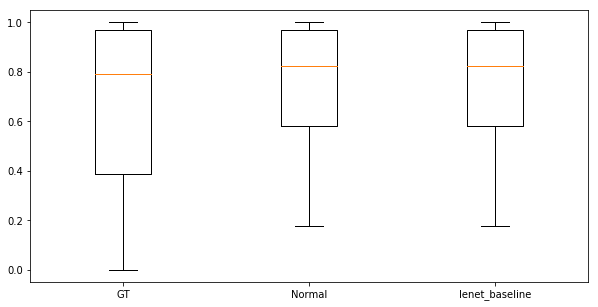

In [29]:
for i,m in enumerate(MODELS):
    plt.figure(figsize=(10,5))
    plt.boxplot([MODELS[m]['confidence_gt'], 
                  MODELS[m]['confidence_normal'], 
                  [elem.item() for elem in MODELS[m]['confidence_pred']], ], labels=['GT','Normal',m])
    plt.show()

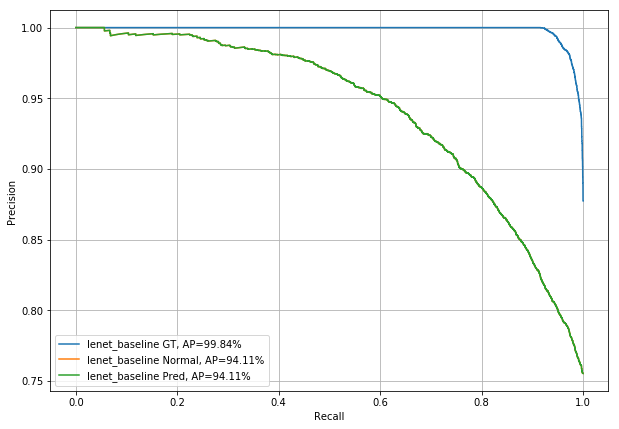

In [30]:
plt.figure(figsize=(10,7))
for i,m in enumerate(MODELS):
    if i>=0:
        plt.plot(MODELS[m]['recall_gt'], MODELS[m]['precision_gt'],
                 label='{} GT, AP={:.2%}'.format(m, MODELS[m]['average_precision_gt']))
        plt.plot(MODELS[m]['recall_normal'], MODELS[m]['precision_normal'],
                 label='{} Normal, AP={:.2%}'.format(m, MODELS[m]['average_precision_normal']))
    plt.plot(MODELS[m]['recall_pred'], MODELS[m]['precision_pred'],
             label='{} Pred, AP={:.2%}'.format(m, MODELS[m]['average_precision_pred']))
    #plt.plot(MODELS[m]['recall_entropy'], MODELS[m]['precision_entropy'],
    #         label='{} Entropy, AP={:.3f}'.format(m, MODELS[m]['average_precision_entropy']))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid()
plt.show()

## Part 3: Accuracy vs Confidence plot

In [357]:
THRESHOLDS = np.concatenate((np.arange(0,1, step=0.05),np.array([0.99])))

In [358]:
def get_accuracy_threshold(accurate, confidence, threshold):
    confidence_above_threshold = confidence>=threshold
    predicted_for_images = np.sum(confidence_above_threshold)
    correct_predictions_above_threshold = np.sum(confidence_above_threshold*accurate)
    return (correct_predictions_above_threshold / predicted_for_images)

In [377]:
for i,m in enumerate(MODELS):
    print('MODEL {}: {}'.format(i,m))    
    MODELS[m]['accuracies_pred'], MODELS[m]['accuracies_gt'] = [], []
    for t in THRESHOLDS:
        cur_acc = get_accuracy_threshold(MODELS[m]['accurate_pred'], MODELS[m]['confidence_pred'], t)
        MODELS[m]['accuracies_pred'].append(cur_acc)
        
        if not 'self_confid' in MODELS[m]['mode']:
            cur_acc = get_accuracy_threshold(MODELS[m]['accurate_gt'], MODELS[m]['confidence_gt'], t)
            MODELS[m]['accuracies_gt'].append(cur_acc)

MODEL 0: resnet50
MODEL 1: resnet50_smoothing


/etudiants/siscol/c/corbi_c2/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


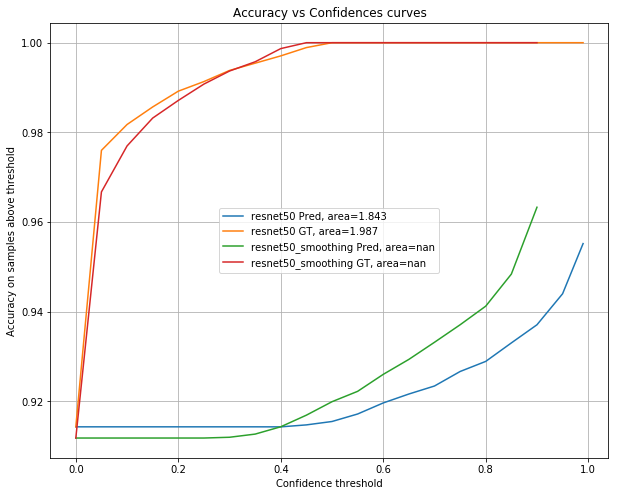

In [378]:
plt.figure(figsize=(10,8))
for i,m in enumerate(MODELS):
    if 'self_confid' in MODELS[m]['mode'] or 'heter' in MODELS[m]['mode']:
        continue
    plt.plot(THRESHOLDS, MODELS[m]['accuracies_pred'], label='{} Pred, area={:.3f}'
             .format(m, np.trapz(MODELS[m]['accuracies_pred'], dx=0.1)))
    plt.plot(THRESHOLDS, MODELS[m]['accuracies_gt'], label='{} GT, area={:.3f}'
             .format(m, np.trapz(MODELS[m]['accuracies_gt'], dx=0.1)))

plt.legend()
plt.xlabel('Confidence threshold')
plt.ylabel('Accuracy on samples above threshold')
plt.title('Accuracy vs Confidences curves')
plt.grid()
plt.show()

## Part 4: Compute calibration plot

In [39]:
from sklearn.calibration import calibration_curve

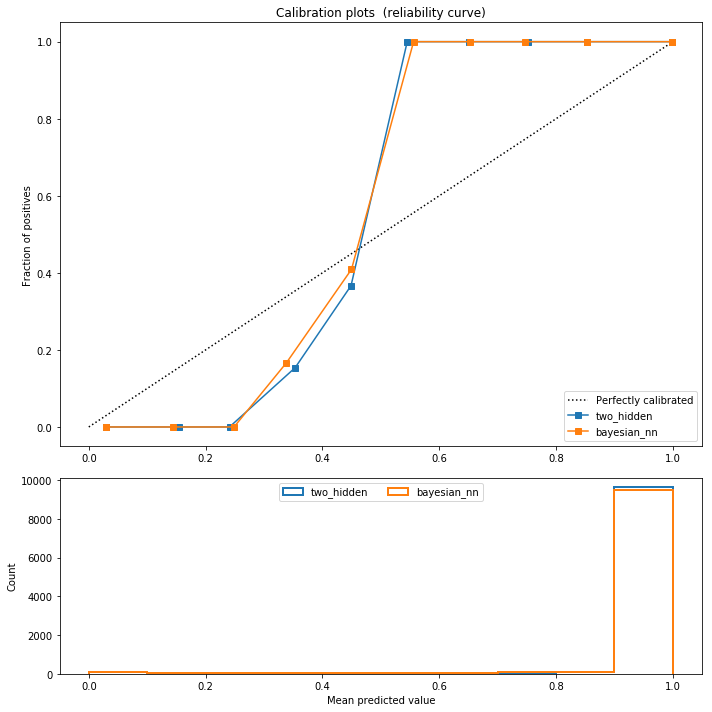

In [40]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

for i,m in enumerate(MODELS):
    if MODELS[m]['self_confid']:
        continue
    fraction_of_positives, mean_predicted_value = calibration_curve(MODELS[m]['accurate_gt'], 
                                                                    MODELS[m]['confidence_gt'], 
                                                                    n_bins=10)
    ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label='{}'.format(m))
    ax2.hist(MODELS[m]['confidence_gt'], range=(0, 1), bins=10, label='{}'.format(m), histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()